In [8]:
import numpy as np
import detectron2
from detectron2.modeling import build_model
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
import glob
import pickle
import cv2
import os
import json
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
jtplot.style(ticks=True, grid=False, figsize=(20, 10))

In [3]:

cfg = get_cfg()
cfg.merge_from_file(r"output/config.yaml")
pred = DefaultPredictor(cfg)
imgpath = glob.glob(r"datasets/cityscapes/leftImg8bit/val/*/*.png")
gtpath = glob.glob(r"datasets/cityscapes/gtFine/val/*/*.json")
imgpath.sort()
gtpath.sort()
print(imgpath[0], gtpath[0])

datasets/cityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png datasets/cityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_polygons.json


In [21]:
# clear proposals folder beforehand
for i in range(500):
    if os.path.exists(r"proposals/img" + str(i) + r".pickle"):
        os.remove(r"proposals/img" + str(i) + r".pickle")

for i in range(500):
    if (i % 100 == 99):
        print("progress: {} / 500".format(i))
    img = cv2.imread(imgpath[i])
    output = pred(img)
    

progress: 99 / 500
progress: 199 / 500
progress: 299 / 500
progress: 399 / 500
progress: 499 / 500


[[1233.0363   383.97656 1292.4501   475.88818]
 [ 852.7683   388.09607  911.0576   477.3354 ]
 [1833.3004   231.64896 2037.954    797.9264 ]
 ...
 [1870.079    243.99399 2048.       468.28525]
 [ 869.94525  372.84503  978.8754   463.2304 ]
 [1864.8834   212.3055  2048.       275.82062]]


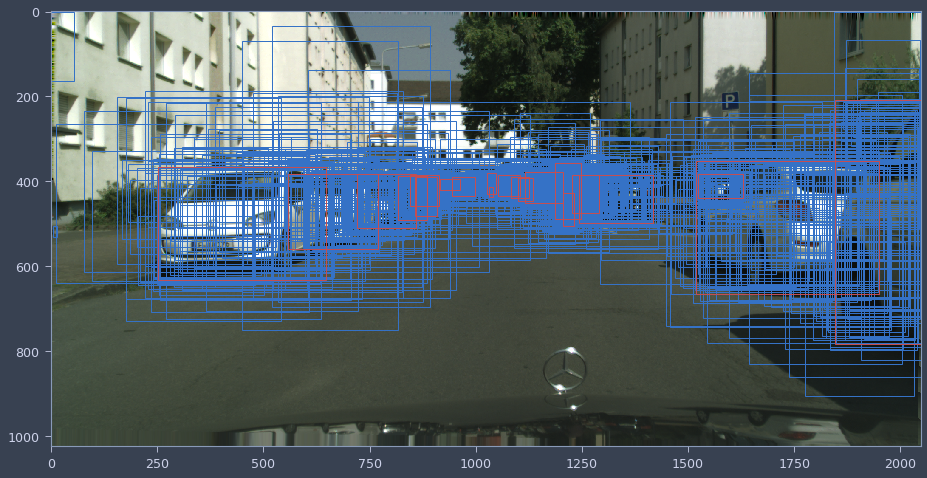

In [30]:
def print_rect(xy, w, h, color):
    plt.gca().add_patch(plt.Rectangle(xy=xy,
    width=w, 
    height=h,
    fill=False, linewidth=1, edgecolor=color))

selection = ['person', 'rider', 'car', 'truck', 'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle']
    
# read pickle files
for i in range(1, 2):
    proposals = None
    with open("proposals/img" + str(i) + ".pickle", "rb") as file:
        proposals = pickle.load(file)
    proposals = proposals[0].proposal_boxes.tensor.cpu().numpy()
    print(proposals)
    img = cv2.imread(imgpath[i])
    b,g,r=cv2.split(img)
    img = cv2.merge([r,g,b])
    plt.imshow(img)
    for box in proposals:
        pass
        print_rect((box[0], box[1]), box[2] - box[0], box[3] - box[1], 'b')
        
    # gt
    with open(gtpath[i], 'r') as file:
        data = file.read()
    gts = json.loads(data)["objects"]
    gtboxes = []# N * 4
    for gt in gts:
        if not gt['label'] in selection:
            continue
        polygon = gt['polygon']
        gtboxes.append([9999, 9999, 0, 0])
        for point in polygon:
            gtboxes[-1][0] = min(gtboxes[-1][0], point[0])
            gtboxes[-1][1] = min(gtboxes[-1][1], point[1])
            gtboxes[-1][2] = max(gtboxes[-1][2], point[0])
            gtboxes[-1][3] = max(gtboxes[-1][3], point[1])
    for box in gtboxes:
        print_rect((box[0], box[1]), box[2] - box[0], box[3] - box[1], 'r')